In [219]:
import os
import mlflow

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy 

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [ ]:
# Читаем редактированный файл с выборкой
df = pd.read_pickle("../data/car_data_edited.pkl")

In [221]:
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,mileage_level
0,ritz,2014,3.349609,5.589844,27000,Petrol,Dealer,Manual,0,mid
1,sx4,2013,4.750000,9.539062,43000,Diesel,Dealer,Manual,0,mid
2,ciaz,2017,7.250000,9.851562,6900,Petrol,Dealer,Manual,0,low
3,wagon r,2011,2.849609,4.148438,5200,Petrol,Dealer,Manual,0,low
4,swift,2014,4.601562,6.871094,42450,Diesel,Dealer,Manual,0,mid


In [ ]:
# Переименовываем столбец 'Selling_Price' в 'target'
df = df.rename(columns={'Selling_Price': 'target'})

In [223]:
df.head(5)

,Car_Name,Year,target,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,mileage_level
0,ritz,2014,3.349609,5.589844,27000,Petrol,Dealer,Manual,0,mid
1,sx4,2013,4.750000,9.539062,43000,Diesel,Dealer,Manual,0,mid
2,ciaz,2017,7.250000,9.851562,6900,Petrol,Dealer,Manual,0,low
3,wagon r,2011,2.849609,4.148438,5200,Petrol,Dealer,Manual,0,low
4,swift,2014,4.601562,6.871094,42450,Diesel,Dealer,Manual,0,mid


In [ ]:
# Разбиение выборки на тестовую и обучающую
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=7)

In [ ]:
# Категориальные признаки
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['Car_Name',
 'Year',
 'Fuel_Type',
 'Selling_type',
 'Transmission',
 'mileage_level']

In [ ]:
# Числовые признаки
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['Present_Price', 'Driven_kms', 'Owner']

In [ ]:
# Определяем скейлер, энкодер и регрессор
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999) # unknown_value нужно выбирать с умом
regressor = RandomForestRegressor()

In [ ]:
# Создаем препроцессор для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [ ]:
# Создаем пайплайн и обучаем модель
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level'])])),
                ('model', RandomForestRegressor())])

In [ ]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

In [231]:
# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [232]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "estate_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "estate_model_rf"

In [233]:
# Обязательно логируем сигнатуру модели и пример входных данных. Подготовим их
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [234]:
# Будем логировать requirements и артефакт - текстовый файл
req_file = '../requirements.txt'
art = '../comment.txt'

In [235]:
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
#params_dict = {'n_estimators': 10, 'max_depth': 10}
params_dict = pipeline.get_params()

In [236]:
# Когда создаем новый эксперимент, то: 
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
#experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

RestException: RESOURCE_ALREADY_EXISTS: Experiment(name=estate_project) already exists. Error: (raised as a result of Query-invoked autoflush; consider using a session.no_autoflush block if this flush is occurring prematurely)
(sqlite3.IntegrityError) UNIQUE constraint failed: experiments.name
[SQL: INSERT INTO experiments (name, artifact_location, lifecycle_stage, creation_time, last_update_time) VALUES (?, ?, ?, ?, ?)]
[parameters: ('estate_project', '', 'active', 1731844596175, 1731844596175)]
(Background on this error at: https://sqlalche.me/e/20/gkpj)

In [ ]:
# mlflow.sklearn.autolog()

# with mlflow.start_run(run_name='auto', experiment_id=experiment_id) as run:
#     pipeline.fit(X_train, y_train)

In [ ]:
regressor2 = RandomForestRegressor(n_estimators=10, max_depth=6)

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor2)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level'])])),
                ('model', RandomForestRegressor(max_depth=6, n_estimators=10))])

In [ ]:
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.7393530272480164,
 'mape': 0.2129686775257678,
 'mse': 1.8671792935421307}

In [ ]:
RUN_NAME = 'smaller_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')


2024/11/17 14:38:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run smaller_model at: http://127.0.0.1:5000/#/experiments/1/runs/cd8851eba052415b932abfe114a0ff45.
2024/11/17 14:38:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [ ]:
regressor3 = CatBoostRegressor()

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor3)])

pipeline.fit(X_train, y_train)

Learning rate set to 0.032324
0:	learn: 4.7153467	total: 826us	remaining: 826ms
1:	learn: 4.6370845	total: 1.82ms	remaining: 909ms
2:	learn: 4.5568435	total: 2.38ms	remaining: 793ms
3:	learn: 4.4847538	total: 2.92ms	remaining: 726ms
4:	learn: 4.4233423	total: 3.78ms	remaining: 753ms
5:	learn: 4.3465459	total: 4.32ms	remaining: 715ms
6:	learn: 4.2789600	total: 5.07ms	remaining: 720ms
7:	learn: 4.2092038	total: 5.81ms	remaining: 720ms
8:	learn: 4.1522367	total: 6.47ms	remaining: 712ms
9:	learn: 4.0893077	total: 7.17ms	remaining: 710ms
10:	learn: 4.0285265	total: 10.1ms	remaining: 908ms
11:	learn: 3.9669526	total: 11ms	remaining: 908ms
12:	learn: 3.9087721	total: 12.2ms	remaining: 926ms
13:	learn: 3.8557176	total: 12.9ms	remaining: 906ms
14:	learn: 3.8029993	total: 13.6ms	remaining: 895ms
15:	learn: 3.7429440	total: 14.3ms	remaining: 881ms
16:	learn: 3.6791326	total: 14.9ms	remaining: 864ms
17:	learn: 3.6310104	total: 16.7ms	remaining: 913ms
18:	learn: 3.5737747	total: 18.4ms	remaining: 9

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x000002A042AA4850>)])

In [ ]:
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.9270591269280699,
 'mape': 0.5746140589734728,
 'mse': 2.14151799141817}

In [ ]:
RUN_NAME = 'catboost_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')


2024/11/17 14:38:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run catboost_model at: http://127.0.0.1:5000/#/experiments/1/runs/21b3243b34a54b439d11b77bea63b720.
2024/11/17 14:38:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [ ]:
metrics = {}

In [ ]:
class MlExperiment():
    def __init__(self, RUN_NAME, EXPERIMENT_NAME, preprocessor, regressor) -> None:
        self.RUN_NAME = RUN_NAME
        self.EXPERIMENT_NAME = EXPERIMENT_NAME
        self.pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

    def model_fit(self, X_train, y_train):
        self.pipeline.fit(X_train, y_train)  
          
    def model_predict(self, X_test, y_test):
        predictions = self.pipeline.predict(X_test) 
        self.metrics = {}
        self.metrics["mae"] = mean_absolute_error(y_test, predictions)   
        self.metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
        self.metrics["mse"] = mean_squared_error(y_test, predictions)


    def start_run(self, signature, input_example, art):
        experiment_id = mlflow.get_experiment_by_name(self.EXPERIMENT_NAME).experiment_id
        with mlflow.start_run(run_name=self.RUN_NAME, experiment_id=experiment_id) as run:
            # получаем уникальный идентификатор запуска эксперимента
            run_id = run.info.run_id 
            mlflow.sklearn.log_model(self.pipeline, 
                                    artifact_path="models",
                                    signature=signature,
                                    input_example=input_example,
                                    pip_requirements=req_file
                                    )
            mlflow.log_metrics(self.metrics)
            mlflow.log_artifact(art)
            mlflow.log_params(self.pipeline.get_params())

        run = mlflow.get_run(run_id) 
        assert (run.info.status =='FINISHED')

        
        

In [ ]:
new_exp = MlExperiment('test', EXPERIMENT_NAME, preprocessor, LinearRegression())

In [ ]:
new_exp.model_fit(X_train, y_train)

In [ ]:
new_exp.model_predict(X_test, y_test)

In [ ]:
new_exp.start_run(signature, input_example, art)

2024/11/17 14:38:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run test at: http://127.0.0.1:5000/#/experiments/1/runs/a0f3f52c919044c699f2d00f2a3fba61.
2024/11/17 14:38:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [ ]:
new_exp.metrics

{'mae': 70784.18849628385,
 'mape': 113691.08561923874,
 'mse': 22104121189.169464}

# Feature engineering

In [ ]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler

In [ ]:
X_train_sklearn = X_train.copy()

In [ ]:
pf = PolynomialFeatures(degree=2)

In [ ]:
X_train_sklearn


,Car_Name,Year,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,mileage_level
116,Royal Enfield Classic 350,2013,1.469727,33000,Petrol,Individual,Manual,0,mid
162,Bajaj Pulsar NS 200,2012,0.990234,14500,Petrol,Individual,Manual,0,low
134,TVS Apache RTR 160,2017,0.810059,11800,Petrol,Individual,Manual,0,low
62,fortuner,2014,35.968750,78000,Diesel,Dealer,Automatic,0,high
175,Hero Honda CBZ extreme,2011,0.787109,75000,Petrol,Individual,Manual,0,high
...,...,...,...,...,...,...,...,...,...
213,i20,2011,6.789062,31604,Petrol,Dealer,Manual,0,mid
68,corolla altis,2011,13.742188,88000,Petrol,Dealer,Manual,0,high
26,swift,2013,5.871094,55138,Petrol,Dealer,Manual,0,high
198,Bajaj Discover 125,2011,0.569824,35000,Petrol,Individual,Manual,1,mid


In [ ]:
pf.fit_transform(X_train_sklearn[['Present_Price', 'Driven_kms']])


array([[1.00000000e+00, 1.46972656e+00, 3.30000000e+04, 2.16009617e+00,
        4.85009766e+04, 1.08900000e+09],
       [1.00000000e+00, 9.90234375e-01, 1.45000000e+04, 9.80564117e-01,
        1.43583984e+04, 2.10250000e+08],
       [1.00000000e+00, 8.10058594e-01, 1.18000000e+04, 6.56194925e-01,
        9.55869141e+03, 1.39240000e+08],
       ...,
       [1.00000000e+00, 5.87109375e+00, 5.51380000e+04, 3.44697418e+01,
        3.23720367e+05, 3.04019904e+09],
       [1.00000000e+00, 5.69824219e-01, 3.50000000e+04, 3.24699640e-01,
        1.99438477e+04, 1.22500000e+09],
       [1.00000000e+00, 5.69824219e-01, 2.40000000e+04, 3.24699640e-01,
        1.36757812e+04, 5.76000000e+08]])

In [ ]:
sp = SplineTransformer(n_knots=3, degree=3)

In [ ]:
sp.fit_transform(X_train_sklearn[['Driven_kms']])

array([[1.09701260e-01, 6.50834618e-01, 2.39096855e-01, 3.67267367e-04,
        0.00000000e+00],
       [1.40180422e-01, 6.63612457e-01, 1.96177763e-01, 2.93573172e-05,
        0.00000000e+00],
       [1.45052173e-01, 6.64665846e-01, 1.90266544e-01, 1.54371665e-05,
        0.00000000e+00],
       ...,
       [7.94665211e-02, 6.24041272e-01, 2.94747121e-01, 1.74508522e-03,
        0.00000000e+00],
       [1.06699342e-01, 6.48902507e-01, 2.43958822e-01, 4.39328668e-04,
        0.00000000e+00],
       [1.23907622e-01, 6.58229508e-01, 2.17724023e-01, 1.38846791e-04,
        0.00000000e+00]])

In [ ]:
qt = QuantileTransformer()

In [ ]:
qt.fit_transform(X_train_sklearn[['Driven_kms']])

d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(


array([[0.51793722],
       [0.19730942],
       [0.15695067],
       [0.93946188],
       [0.92376682],
       [0.03587444],
       [0.9103139 ],
       [0.98206278],
       [0.73542601],
       [0.72197309],
       [0.79372197],
       [0.29596413],
       [0.1793722 ],
       [0.08520179],
       [0.1838565 ],
       [0.75336323],
       [0.89686099],
       [0.89237668],
       [0.47982063],
       [0.93273543],
       [0.31390135],
       [0.21524664],
       [0.41704036],
       [0.67713004],
       [0.66367713],
       [0.52914798],
       [0.0896861 ],
       [0.13901345],
       [0.90134529],
       [0.44394619],
       [0.78923767],
       [0.87668161],
       [0.40358744],
       [0.78475336],
       [0.32286996],
       [0.70179372],
       [0.68161435],
       [0.98654709],
       [0.62780269],
       [0.6367713 ],
       [0.86547085],
       [0.34529148],
       [0.09865471],
       [0.25112108],
       [0.28475336],
       [0.54932735],
       [0.77130045],
       [0.273

In [ ]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
sp = SplineTransformer(n_knots=3, degree=3)

In [ ]:
# Значения преобразованных признаков нужно отскейлить, поэтому создаем pipeline из двух шагов - преобразование и скейлинг
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

In [ ]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt,num_features),
        ('poly', pf_pipeline, ['Present_Price', 'Driven_kms']), # В преобразования добавляем созданный ранее pipeline
        ('spline', sp, ['Driven_kms'])
    ],
    remainder='drop',
    ) # Удаляем столбцы, которые не затронуты преобразования

In [ ]:
X_train_sklearn[['Present_Price', 'Driven_kms']] = X_train_sklearn[['Present_Price', 'Driven_kms']].astype('float64')
X_train_sklearn[['Present_Price', 'Driven_kms']] = X_train_sklearn[['Present_Price', 'Driven_kms']].astype('float64')


In [ ]:
X_train_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_sklearn)
X_train_sklearn = pd.DataFrame(X_train_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(


In [ ]:
# Удобно использовать для отображения всех строк\столбцов в DataFrame
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_sklearn)

,num__Present_Price,num__Driven_kms,num__Owner,cat__Car_Name,cat__Year,cat__Fuel_Type,cat__Selling_type,cat__Transmission,cat__mileage_level,quantile__Present_Price,quantile__Driven_kms,quantile__Owner,poly__1,poly__Present_Price,poly__Driven_kms,poly__Present_Price^2,poly__Present_Price Driven_kms,poly__Driven_kms^2,spline__Driven_kms_sp_0,spline__Driven_kms_sp_1,spline__Driven_kms_sp_2,spline__Driven_kms_sp_3,spline__Driven_kms_sp_4
0,-0.673208,-0.112090,-0.165900,38.0,10.0,2.0,1.0,1.0,2.0,0.280269,0.517937,0.0,0.0,-0.673208,-0.112090,-0.215020,-0.425486,-0.118363,0.109701,0.650835,0.239097,0.000367,0.0
1,-0.728080,-0.563611,-0.165900,13.0,9.0,2.0,1.0,1.0,1.0,0.246637,0.197309,0.0,0.0,-0.728080,-0.563611,-0.216997,-0.474820,-0.170291,0.140180,0.663612,0.196178,0.000029,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,-0.776191,-0.063277,6.027714,9.0,8.0,2.0,1.0,1.0,2.0,0.082960,0.549327,1.0,0.0,-0.776191,-0.063277,-0.218097,-0.466749,-0.110326,0.106699,0.648903,0.243959,0.000439,0.0
223,-0.776191,-0.331749,-0.165900,25.0,13.0,2.0,1.0,0.0,2.0,0.082960,0.385650,0.0,0.0,-0.776191,-0.331749,-0.218097,-0.475806,-0.148678,0.123908,0.658230,0.217724,0.000139,0.0


In [ ]:
new = MlExperiment('fe_sklearn', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
new.model_fit(X_train, y_train)
new.model_predict(X_test, y_test)
new.start_run(signature, input_example, art)

d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(
2024/11/17 14:38:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/1/runs/f71f22ca2fba42e695ed645c83c77f6b.
2024/11/17 14:38:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [ ]:
new.pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('model', RandomForestRegressor())])

#### FEATURE SELECTION

#### Используем sklearn признаки

In [ ]:
from sklearn.feature_selection import RFE
X_train_sklearn

,num__Present_Price,num__Driven_kms,num__Owner,cat__Car_Name,cat__Year,cat__Fuel_Type,cat__Selling_type,cat__Transmission,cat__mileage_level,quantile__Present_Price,...,poly__Present_Price,poly__Driven_kms,poly__Present_Price^2,poly__Present_Price Driven_kms,poly__Driven_kms^2,spline__Driven_kms_sp_0,spline__Driven_kms_sp_1,spline__Driven_kms_sp_2,spline__Driven_kms_sp_3,spline__Driven_kms_sp_4
0,-0.673208,-0.112090,-0.165900,38.0,10.0,2.0,1.0,1.0,2.0,0.280269,...,-0.673208,-0.112090,-0.215020,-0.425486,-0.118363,0.109701,0.650835,0.239097,0.000367,0.0
1,-0.728080,-0.563611,-0.165900,13.0,9.0,2.0,1.0,1.0,1.0,0.246637,...,-0.728080,-0.563611,-0.216997,-0.474820,-0.170291,0.140180,0.663612,0.196178,0.000029,0.0
2,-0.748699,-0.629509,-0.165900,43.0,14.0,2.0,1.0,1.0,1.0,0.161435,...,-0.748699,-0.629509,-0.217541,-0.481755,-0.174488,0.145052,0.664666,0.190267,0.000015,0.0
3,3.274785,0.986205,-0.165900,67.0,11.0,1.0,0.0,0.0,0.0,0.988789,...,3.274785,0.986205,1.950290,3.558282,0.176811,0.054678,0.585314,0.355028,0.004980,0.0
4,-0.751325,0.912985,-0.165900,18.0,8.0,2.0,1.0,1.0,0.0,0.141256,...,-0.751325,0.912985,-0.217603,-0.410268,0.149687,0.057585,0.590956,0.347035,0.004424,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,-0.064475,-0.146162,-0.165900,70.0,8.0,2.0,0.0,1.0,2.0,0.533632,...,-0.064475,-0.146162,-0.141371,-0.185540,-0.123692,0.111830,0.652122,0.235726,0.000322,0.0
220,0.731226,1.230271,-0.165900,58.0,8.0,2.0,0.0,1.0,0.0,0.892377,...,0.731226,1.230271,0.097956,1.251808,0.274907,0.045697,0.565423,0.381713,0.007167,0.0
221,-0.169525,0.428222,-0.165900,78.0,10.0,2.0,0.0,1.0,0.0,0.479821,...,-0.169525,0.428222,-0.160854,-0.027813,-0.003059,0.079467,0.624041,0.294747,0.001745,0.0
222,-0.776191,-0.063277,6.027714,9.0,8.0,2.0,1.0,1.0,2.0,0.082960,...,-0.776191,-0.063277,-0.218097,-0.466749,-0.110326,0.106699,0.648903,0.243959,0.000439,0.0


In [243]:
rfe_skl_selector = RFE(estimator=regressor, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_skl_rfe = rfe_skl_selector.fit_transform(X_train_sklearn,y_train)

In [244]:
X_train_skl_rfe = pd.DataFrame(X_train_skl_rfe, columns=rfe_skl_selector.get_feature_names_out())
X_train_skl_rfe

,num__Present_Price,num__Driven_kms,cat__Car_Name,cat__Year,cat__Fuel_Type,quantile__Present_Price,quantile__Driven_kms,poly__Present_Price,poly__Present_Price^2,poly__Present_Price Driven_kms,spline__Driven_kms_sp_2,spline__Driven_kms_sp_3
0,-0.673208,-0.112090,38.0,10.0,2.0,0.280269,0.517937,-0.673208,-0.215020,-0.425486,0.239097,0.000367
1,-0.728080,-0.563611,13.0,9.0,2.0,0.246637,0.197309,-0.728080,-0.216997,-0.474820,0.196178,0.000029
2,-0.748699,-0.629509,43.0,14.0,2.0,0.161435,0.156951,-0.748699,-0.217541,-0.481755,0.190267,0.000015
3,3.274785,0.986205,67.0,11.0,1.0,0.988789,0.939462,3.274785,1.950290,3.558282,0.355028,0.004980
4,-0.751325,0.912985,18.0,8.0,2.0,0.141256,0.923767,-0.751325,-0.217603,-0.410268,0.347035,0.004424
...,...,...,...,...,...,...,...,...,...,...,...,...
219,-0.064475,-0.146162,70.0,8.0,2.0,0.533632,0.497758,-0.064475,-0.141371,-0.185540,0.235726,0.000322
220,0.731226,1.230271,58.0,8.0,2.0,0.892377,0.959641,0.731226,0.097956,1.251808,0.381713,0.007167
221,-0.169525,0.428222,78.0,10.0,2.0,0.479821,0.829596,-0.169525,-0.160854,-0.027813,0.294747,0.001745
222,-0.776191,-0.063277,9.0,8.0,2.0,0.082960,0.549327,-0.776191,-0.218097,-0.466749,0.243959,0.000439


In [245]:
rfe_cols = X_train_skl_rfe.columns.tolist()
rfe_cols

['num__Present_Price',
 'num__Driven_kms',
 'cat__Car_Name',
 'cat__Year',
 'cat__Fuel_Type',
 'quantile__Present_Price',
 'quantile__Driven_kms',
 'poly__Present_Price',
 'poly__Present_Price^2',
 'poly__Present_Price Driven_kms',
 'spline__Driven_kms_sp_2',
 'spline__Driven_kms_sp_3']

In [246]:
rfe_idx = rfe_skl_selector.support_
rfe_idx

array([ True,  True, False,  True,  True,  True, False, False, False,
        True,  True, False, False,  True, False,  True,  True, False,
       False, False,  True,  True, False])

In [247]:
# Отбираемые столбцы нужно залогировать, иначе мы потеряем информацию о том, какие призныки выбраны
with open('rfe_skl_idx.txt', 'w+') as f:
    f.write(str(rfe_idx))
with open('rfe_skl_cols.txt', 'w+') as f:
    f.write(str(rfe_cols))

In [248]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [ ]:
rfe_skl_pipeline  = MlExperiment('rfe_feature_selection', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
rfe_skl_pipeline.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', regressor)
])
rfe_skl_pipeline.model_fit(X_train, y_train)
rfe_skl_pipeline.model_predict(X_test, y_test)
rfe_skl_pipeline.start_run(signature, input_example, art)

d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(
2024/11/17 15:05:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/dd20bfa3ce3d451ab9fd4dcb790dea99.
2024/11/17 15:05:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [250]:
rfe_skl_pipeline .metrics

{'mae': 0.7254407063802085,
 'mape': 0.20697713173969348,
 'mse': 1.9656739575897257}

#### mlextend

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [ ]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_train_sklearn,y_train)

SequentialFeatureSelector(cv=2, estimator=RandomForestRegressor(n_estimators=3),
                          k_features=(3, 3), scoring='neg_mean_absolute_error')

In [ ]:
selected_features_sfs = X_train_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

,cat__Year,cat__Selling_type,poly__Present_Price
0,10.0,1.0,-0.673208
1,9.0,1.0,-0.728080
2,14.0,1.0,-0.748699
3,11.0,0.0,3.274785
4,8.0,1.0,-0.751325
...,...,...,...
219,8.0,0.0,-0.064475
220,8.0,0.0,0.731226
221,10.0,0.0,-0.169525
222,8.0,1.0,-0.776191


In [ ]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['cat__Year', 'cat__Selling_type', 'poly__Present_Price']

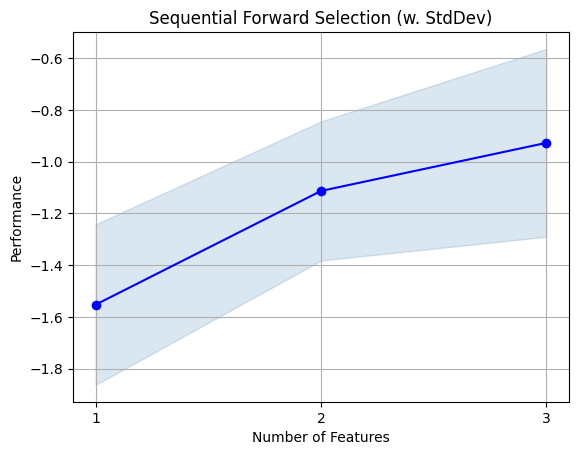

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
rfe_sfs_pipeline  = MlExperiment('rfs_feature_selection', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
rfe_sfs_pipeline.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])
rfe_sfs_pipeline.model_fit(X_train, y_train)
rfe_sfs_pipeline.model_predict(X_test, y_test)
rfe_sfs_pipeline.start_run(signature, input_example, art)


d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(
2024/11/17 15:07:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/a51011caaee347ed8549ef74f79925ac.
2024/11/17 15:07:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [252]:
rfe_sfs_pipeline.metrics

{'mae': 0.8603937882146427,
 'mape': 0.1678031742010104,
 'mse': 2.472747399064225}

#### HYPERPARAMS

Gridsearch

In [253]:
from sklearn.model_selection import  GridSearchCV

In [254]:
param_grid = {
    'model__depth': [1,3,5]
}

In [262]:
gs = GridSearchCV(rfe_sfs_pipeline.pipeline, param_grid, cv=2, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)
print("Лучшие гиперпараметры:", gs.best_params_)

ValueError: Invalid parameter 'depth' for estimator RandomForestRegressor(). Valid parameters are: ['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

#### Optuna

In [265]:
import optuna

d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [266]:
def objective(trial):
    # предлагаем гиперпараметры
    depth = trial.suggest_int('depth', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)

    # создаём и обучаем модель
    opt_pipeline  = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
        ('model', CatBoostRegressor(depth=depth, learning_rate=learning_rate, verbose=0))
    ])

    opt_pipeline.fit(X_train, y_train)

    # предсказываем и вычисляем RMSE
    preds = opt_pipeline.predict(X_test)
    mae =  mean_absolute_error(y_test, preds)   

    return mae

In [267]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# выводим результаты
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

[I 2024-11-17 15:25:35,754] A new study created in memory with name: no-name-233a3f28-7272-43b1-a7e9-a4fc3fc22a30
d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(
[I 2024-11-17 15:25:39,089] Trial 0 finished with value: 0.974086520948711 and parameters: {'depth': 10, 'learning_rate': 0.022671368847548497}. Best is trial 0 with value: 0.974086520948711.
d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(
[I 2024-11-17 15:25:39,558] Trial 1 finished with value: 1.46039842779414 and parameters: {'depth': 1, 'learning_rate': 0.06892308602232229}. Best is trial 0 with value: 0.974086520948711.
d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-pac

Number of finished trials: 10
Best trial: {'depth': 2, 'learning_rate': 0.09374306584967798}


In [268]:
optuna_model  = MlExperiment('optuna_model', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
optuna_model.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', CatBoostRegressor(depth=3, learning_rate=0.02789))
])
optuna_model.model_fit(X_train, y_train)
optuna_model.model_predict(X_test, y_test)
optuna_model.start_run(signature, input_example, art)


d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(


0:	learn: 4.7304473	total: 378us	remaining: 378ms
1:	learn: 4.6542481	total: 660us	remaining: 329ms
2:	learn: 4.5857639	total: 899us	remaining: 299ms
3:	learn: 4.5189757	total: 1.14ms	remaining: 284ms
4:	learn: 4.4481048	total: 1.38ms	remaining: 274ms
5:	learn: 4.3869511	total: 1.65ms	remaining: 274ms
6:	learn: 4.3232142	total: 1.97ms	remaining: 280ms
7:	learn: 4.2667173	total: 2.25ms	remaining: 280ms
8:	learn: 4.2076597	total: 2.54ms	remaining: 280ms
9:	learn: 4.1547816	total: 2.82ms	remaining: 279ms
10:	learn: 4.0960791	total: 3.12ms	remaining: 281ms
11:	learn: 4.0422148	total: 3.38ms	remaining: 278ms
12:	learn: 3.9938703	total: 3.62ms	remaining: 275ms
13:	learn: 3.9409344	total: 3.84ms	remaining: 270ms
14:	learn: 3.8893834	total: 4.06ms	remaining: 267ms
15:	learn: 3.8366394	total: 4.44ms	remaining: 273ms
16:	learn: 3.7890147	total: 4.71ms	remaining: 272ms
17:	learn: 3.7410324	total: 4.95ms	remaining: 270ms
18:	learn: 3.6971790	total: 5.17ms	remaining: 267ms
19:	learn: 3.6483465	tota

2024/11/17 15:27:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run optuna_model at: http://127.0.0.1:5000/#/experiments/1/runs/b636e91ad4b34776ac9e058ae851c052.
2024/11/17 15:27:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [269]:
optuna_model.metrics

{'mae': 0.9141945418421892,
 'mape': 0.19234393093307317,
 'mse': 2.893310015926086}

### Лучшая модель

In [296]:
df = pd.read_pickle("../data/car_data_edited.pkl")
df = df.rename(columns={'Selling_Price': 'target'})



In [297]:
Y = df['target']
X = df.drop('target', axis=1)

In [300]:
prod_model  = MlExperiment('production', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
prod_model.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', regressor)
])
prod_model.model_fit(X, Y)
prod_model.model_predict(X, Y)
prod_model.start_run(signature, input_example, art)
prod_model.metrics

d:\Учёба\maga\3 sem\Mohov\IIS_LR1\venv\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (299). n_quantiles is set to n_samples.
  warnings.warn(
2024/11/17 15:34:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run production at: http://127.0.0.1:5000/#/experiments/1/runs/013a2a3283ee4a5d8544ca80d1033c6b.
2024/11/17 15:34:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


{'mae': 0.22421050310932275,
 'mape': 0.06191070568480853,
 'mse': 0.32723364602169874}

In [301]:
import pickle

In [302]:
model_prod = "model_prod.pkl"  

with open(model_prod, 'wb') as file:  
    pickle.dump(prod_model.pipeline, file)